## Базовый анализ и расширение данных

In [1]:
#Импорт модулей
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

In [2]:
#Чтение файла
taxi_data = pd.read_csv(r"d:\IDE_github\mathml\data\train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах

### Временные рамки

In [3]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
min_data = min(taxi_data['pickup_datetime'].values)
max_data = max(taxi_data['pickup_datetime'].values)
print(f'Временные рамки:\nрання дата {min_data}\nпоздняя дата {max_data}')

Временные рамки:
рання дата 2016-01-01T00:00:17.000000000
поздняя дата 2016-06-30T23:59:39.000000000


### Пропущенные значения

In [4]:
empty_values_sum = taxi_data.isna().sum()
#Столбцы с пропусками
columns_with_missing = empty_values_sum[empty_values_sum > 0]
if columns_with_missing.empty:
    print('Пропусков в данных нет')
else:
    print('Столбцы с пропусками:')
    for column, count in columns_with_missing.items():
        print(f'  {column}: {count} пропусков')

Пропусков в данных нет


### Статистические характеристики

In [5]:
#Количество уникальных таксопарков
unique_vendors = taxi_data['vendor_id'].nunique()
print(f"Уникальных таксопарков: {unique_vendors}")
#Максимальное количество пассажиров
max_passengers = taxi_data['passenger_count'].max()
print(f"Максимальное количество пассажиров: {max_passengers}")
#Средняя и медианная длительность поездки (округлено до целого)
mean_duration = round(taxi_data['trip_duration'].mean())
median_duration = round(taxi_data['trip_duration'].median())
print(f"Средняя длительность: {mean_duration} секунд")
print(f"Медианная длительность: {median_duration} секунд")
#Минимальное и максимальное время поездки
min_duration = taxi_data['trip_duration'].min()
max_duration = taxi_data['trip_duration'].max()
print(f"Минимальное время поездки: {min_duration} секунд")
print(f"Максимальное время поездки: {max_duration} секунд")

Уникальных таксопарков: 2
Максимальное количество пассажиров: 9
Средняя длительность: 959 секунд
Медианная длительность: 662 секунд
Минимальное время поездки: 1 секунд
Максимальное время поездки: 3526282 секунд


Судя по последним характеристикам, в данных есть выбросы

### Даты поездок

In [6]:
def add_datetime_features(df):
    """
    Добавляет в DataFrame признаки из datetime.
    Parameters:
    df (pd.DataFrame): Исходный DataFrame с колонкой 'pickup_datetime'
    Returns:
    pd.DataFrame: DataFrame с добавленными колонками
    """
    #Создаем копию DataFrame чтобы избежать предупреждений
    df = df.copy()
    #Добавляем новые признаки
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek  # 0-понедельник, 6-воскресенье
    return df

#Применяем функцию к данным
taxi_data = add_datetime_features(taxi_data)

#Поездки в субботу (день недели = 5, т.к. понедельник=0, воскресенье=6)
saturday_trips = taxi_data[taxi_data['pickup_day_of_week'] == 5].shape[0]
print(f"Поездок в субботу: {saturday_trips}")
#Среднее количество поездок в день
trips_per_day = taxi_data.groupby('pickup_date').size()  #Количество поездок по дням
avg_trips_per_day = round(trips_per_day.mean())
print(f"Среднее количество поездок в день: {avg_trips_per_day}")

Поездок в субботу: 220868
Среднее количество поездок в день: 8015


### Создание признаков на датасете о праздниках

In [7]:
holiday_data = pd.read_csv(r'd:\IDE_github\mathml\data\holiday_data.csv', sep=';')
def add_holiday_features(taxi_df, holiday_df):
    """
    Добавляет признак праздничного дня в DataFrame с поездками.
    
    Parameters:
    taxi_df (pd.DataFrame): DataFrame с поездками и колонкой 'pickup_date'
    holiday_df (pd.DataFrame): DataFrame с праздничными днями
    
    Returns:
    pd.DataFrame: DataFrame с добавленным столбцом 'pickup_holiday'
    """
    #Создаем копию чтобы избежать предупреждений
    taxi_df = taxi_df.copy()
    #Преобразование в формат .datetime
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    #Создаем множество праздничных дат для быстрого поиска
    holiday_dates = set(holiday_df['date'].dt.date)
    #Добавляем бинарный признак праздника
    taxi_df['pickup_holiday'] = taxi_df['pickup_datetime'].dt.date.isin(holiday_dates).astype(int)
    return taxi_df

#Применяем функцию к данным
taxi_data = add_holiday_features(taxi_data, holiday_data)

#Фильтруем только праздничные поездки и вычисляем медиану
holiday_trips = taxi_data[taxi_data['pickup_holiday'] == 1]
median_holiday_duration = round(holiday_trips['trip_duration'].median())
print(f"Медианная длительность поездки в праздничные дни: {median_holiday_duration} секунд")

Медианная длительность поездки в праздничные дни: 585 секунд


### Оптимальный путь из точек

In [8]:
osrm_data = pd.read_csv(r'd:\IDE_github\mathml\data\osrm_data_train.csv')

def add_osrm_features(taxi_df, osrm_df):
    """
    Добавляет OSRM-признаки в DataFrame с поездками.
    
    Parameters:
    taxi_df (pd.DataFrame): DataFrame с поездками
    osrm_df (pd.DataFrame): DataFrame с OSRM данными
    
    Returns:
    pd.DataFrame: DataFrame с добавленными OSRM столбцами
    """
    #Создаем копию чтобы избежать предупреждений
    taxi_df = taxi_df.copy()
    #Объединяем таблицы по id поездки
    taxi_df = taxi_df.merge(
        osrm_df[['id', 'total_distance', 'total_travel_time', 'number_of_steps']],
        on='id',
        how='left'  #left join чтобы сохранить все поездки из taxi_df
    )
    return taxi_df

#Применяем функцию к данным
taxi_data = add_osrm_features(taxi_data, osrm_data)

In [9]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    #Переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    #Радиус земли в километрах
    EARTH_RADIUS = 6371 
    #Считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    #Переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    #Считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [10]:
#Разница между медианной длительностью поездки в данных и из OSRM
median_actual = taxi_data['trip_duration'].median()
median_osrm = taxi_data['total_travel_time'].median()
median_difference = abs(median_actual - median_osrm)
print(f"Разница между медианными длительностями: {median_difference:.0f} секунд")
#Количество пропусков в OSRM столбцах
missing_osrm = taxi_data[['total_distance', 'total_travel_time', 'number_of_steps']].isna().sum()
print("\nПропуски в OSRM столбцах:")
for col, count in missing_osrm.items():
    print(f"   {col}: {count} пропусков")

Разница между медианными длительностями: 372 секунд

Пропуски в OSRM столбцах:
   total_distance: 1 пропусков
   total_travel_time: 1 пропусков
   number_of_steps: 1 пропусков


### Расстояние Хаверсина

In [11]:
def add_geographical_features(df):
    """
    Добавляет географические признаки в DataFrame с поездками.
    
    Parameters:
    df (pd.DataFrame): DataFrame с колонками координат
    
    Returns:
    pd.DataFrame: DataFrame с добавленными географическими признаками
    """
    #Создаем копию чтобы избежать предупреждений
    df = df.copy()
    #Добавляем расстояние Хаверсина
    df['haversine_distance'] = get_haversine_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )
    #Добавляем направление движения
    df['direction'] = get_angle_direction(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )
    return df

#Применяем функцию к данным
taxi_data = add_geographical_features(taxi_data)

#Вычисляем медианное расстояние
median_haversine = taxi_data['haversine_distance'].median()
print(f"Медианное расстояние Хаверсина: {median_haversine:.2f} км")

Медианное расстояние Хаверсина: 2.09 км


### Кластеризация

In [12]:
#Создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
#Обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

from sklearn import cluster
def add_cluster_features(df, kmeans_model):
    """
    Добавляет кластерные признаки в DataFrame с поездками.
    
    Parameters:
    df (pd.DataFrame): DataFrame с колонками координат
    kmeans_model: Обученная модель KMeans
    
    Returns:
    pd.DataFrame: DataFrame с добавленным столбцом geo_cluster
    """
    #Создаем копию чтобы избежать предупреждений
    df = df.copy()
    #Создаем матрицу координат для предсказания
    coords_for_prediction = np.hstack((
        df[['pickup_latitude', 'pickup_longitude']],
        df[['dropoff_latitude', 'dropoff_longitude']]
    ))
    #Предсказываем кластеры для всех поездок
    df['geo_cluster'] = kmeans_model.predict(coords_for_prediction)
    
    return df

#Применяем функцию к данным
taxi_data = add_cluster_features(taxi_data, kmeans)
#Считаем количество поездок в каждом кластере
cluster_counts = taxi_data['geo_cluster'].value_counts()
#Находим размер наименьшего кластера
min_cluster_size = cluster_counts.min()
min_cluster_id = cluster_counts.idxmin()
print(f"Размеры кластеров:")
print(cluster_counts)
print(f"\nНаименьший кластер (ID {min_cluster_id}) содержит {min_cluster_size} поездок")

Размеры кластеров:
geo_cluster
0    595850
6    405045
9    322999
7     45791
3     40671
2     32769
8     15510
4         4
5         3
1         2
Name: count, dtype: int64

Наименьший кластер (ID 1) содержит 2 поездок


### Данные о погоде

In [13]:
weather_data = pd.read_csv(r'd:\IDE_github\mathml\data\weather_data.csv')

def add_weather_features(taxi_df, weather_df):
    """
    Добавляет погодные признаки в DataFrame с поездками.
    
    Parameters:
    taxi_df (pd.DataFrame): DataFrame с поездками и колонкой 'pickup_datetime'
    weather_df (pd.DataFrame): DataFrame с погодными данными
    
    Returns:
    pd.DataFrame: DataFrame с добавленными погодными признаками
    """
    #Создаем копию чтобы избежать предупреждений
    taxi_df = taxi_df.copy()
    weather_df = weather_df.copy()
    #Преобразуем даты в datetime
    weather_df['time'] = pd.to_datetime(weather_df['time'])
    #Извлекаем час из времени посадки для объединения
    taxi_df['pickup_hour'] = taxi_df['pickup_datetime'].dt.floor('h')
    #Объединяем таблицы по времени
    taxi_df = taxi_df.merge(
        weather_df[['time', 'temperature', 'visibility', 'wind speed', 'precip', 'events']],
        left_on='pickup_hour',
        right_on='time',
        how='left'
    )
    #Удаляем временные колонки
    taxi_df = taxi_df.drop(['pickup_hour', 'time'], axis=1)
    return taxi_df

taxi_data = add_weather_features(taxi_data, weather_data)
#Поездки в снежную погоду
snow_trips = taxi_data[taxi_data['events'] == 'Snow'].shape[0]
print(f"Поездок в снежную погоду: {snow_trips}")
#Процент пропусков в погодных столбцах
weather_columns = ['temperature', 'visibility', 'wind speed', 'precip', 'events']
total_rows = len(taxi_data)
missing_percentages = {}
for col in weather_columns:
    missing_count = taxi_data[col].isna().sum()
    percentage = (missing_count / total_rows) * 100
    missing_percentages[col] = percentage
print("\nПроцент пропусков в погодных столбцах:")
for col, percentage in missing_percentages.items():
    print(f"   {col}: {percentage:.2f}%")
#Общий процент пропусков (если нужно среднее по всем столбцам)
avg_missing_percentage = np.mean(list(missing_percentages.values()))
print(f"\nСредний процент пропусков: {avg_missing_percentage:.2f}%")

Поездок в снежную погоду: 13126

Процент пропусков в погодных столбцах:
   temperature: 0.82%
   visibility: 0.82%
   wind speed: 0.82%
   precip: 0.82%
   events: 95.10%

Средний процент пропусков: 19.68%


### Заполнение пропущенных значений в данных о поездках

In [14]:
def fill_null_weather_data(df):
    """
    Заполняет пропущенные значения в таблице с данными о поездках.
    
    Parameters:
    df (pd.DataFrame): DataFrame с данными о поездках
    
    Returns:
    pd.DataFrame: DataFrame с заполненными пропусками
    """
    #Создаем копию чтобы избежать предупреждений
    df = df.copy()
    #Заполняем пропуски в погодных столбцах медианой по дате
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in weather_columns:
        #Вычисляем медиану по дате для каждого столбца
        median_by_date = df.groupby('pickup_date')[col].transform('median')
        # Заполняем пропуски медианой по дате
        df[col] = df[col].fillna(median_by_date)
    #Заполняем пропуски в events строкой 'None'
    df['events'] = df['events'].fillna('None')
    #Заполняем пропуски в OSRM столбцах общей медианой
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in osrm_columns:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)
    return df

#Применяем функцию к данным
taxi_data_filled = fill_null_weather_data(taxi_data)

#Вычисляем медиану температуры после заполнения пропусков
median_temperature = taxi_data_filled['temperature'].median()
rounded_median = round(median_temperature, 1)
print(f"Медиана температуры после заполнения пропусков: {rounded_median}")

Медиана температуры после заполнения пропусков: 11.1


### Диаграмма рассеяния средней скорости движения

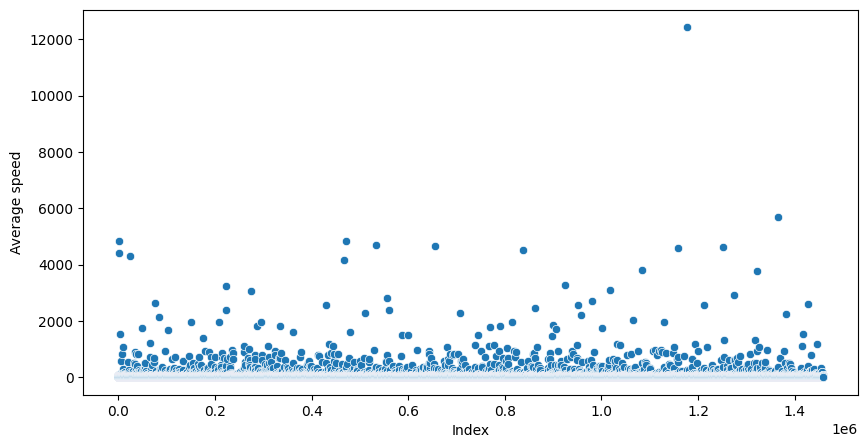

In [15]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

В данных о скорости явно есть выбросы

In [16]:
#Находим и удаляем поездки длительностью более 24 часов (86400 секунд)
long_trip_outliers = taxi_data[taxi_data['trip_duration'] > 86400]
print(f"Количество выбросов по длительности (более 24 часов): {len(long_trip_outliers)}")
#Удаляем эти выбросы
taxi_data_cleaned = taxi_data[taxi_data['trip_duration'] <= 86400].copy()
#Находим и удаляем поездки со средней скоростью более 300 км/ч
#Вычисляем среднюю скорость
taxi_data_cleaned['avg_speed'] = taxi_data_cleaned['total_distance'] / taxi_data_cleaned['trip_duration'] * 3.6
speed_outliers = taxi_data_cleaned[taxi_data_cleaned['avg_speed'] > 300]
print(f"Количество выбросов по скорости (более 300 км/ч): {len(speed_outliers)}")
#Удаляем эти выбросы
taxi_data_final = taxi_data_cleaned[taxi_data_cleaned['avg_speed'] <= 300].copy()
#Удаляем временный столбец avg_speed
taxi_data_final = taxi_data_final.drop('avg_speed', axis=1)
print(f"Размер данных после удаления выбросов: {len(taxi_data_final)} записей")

Количество выбросов по длительности (более 24 часов): 4
Количество выбросов по скорости (более 300 км/ч): 406
Размер данных после удаления выбросов: 1458233 записей


## Разведывательный анализ данных

### Диаграммы зависимости длительности поездки

In [17]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

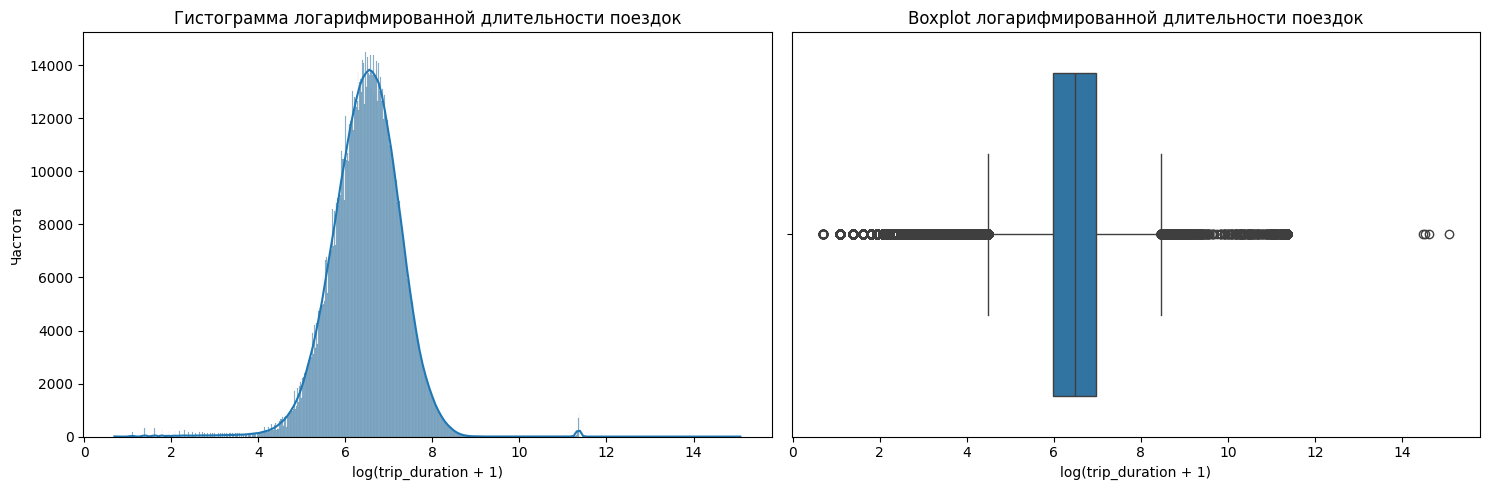

Статистика теста: 148792.91
p-value: 0.00
Распределение НЕ является нормальным (отвергаем нулевую гипотезу)


In [18]:
#Создаем графики
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#Гистограмма с KDE
sns.histplot(taxi_data['trip_duration_log'], kde=True, ax=axes[0])
axes[0].set_title('Гистограмма логарифмированной длительности поездок')
axes[0].set_xlabel('log(trip_duration + 1)')
axes[0].set_ylabel('Частота')
#Коробчатая диаграмма
sns.boxplot(x=taxi_data['trip_duration_log'], ax=axes[1])
axes[1].set_title('Boxplot логарифмированной длительности поездок')
axes[1].set_xlabel('log(trip_duration + 1)')
plt.tight_layout()
plt.show()

#Проводим тест Д'Агостино на нормальность
statistic, p_value = stats.normaltest(taxi_data['trip_duration_log'])
print(f"Статистика теста: {statistic:.2f}")
print(f"p-value: {p_value:.2f}")
#Проверяем гипотезу на уровне значимости α=0.05
alpha = 0.05
if p_value < alpha:
    print("Распределение НЕ является нормальным (отвергаем нулевую гипотезу)")
else:
    print("Распределение является нормальным (не отвергаем нулевую гипотезу)")

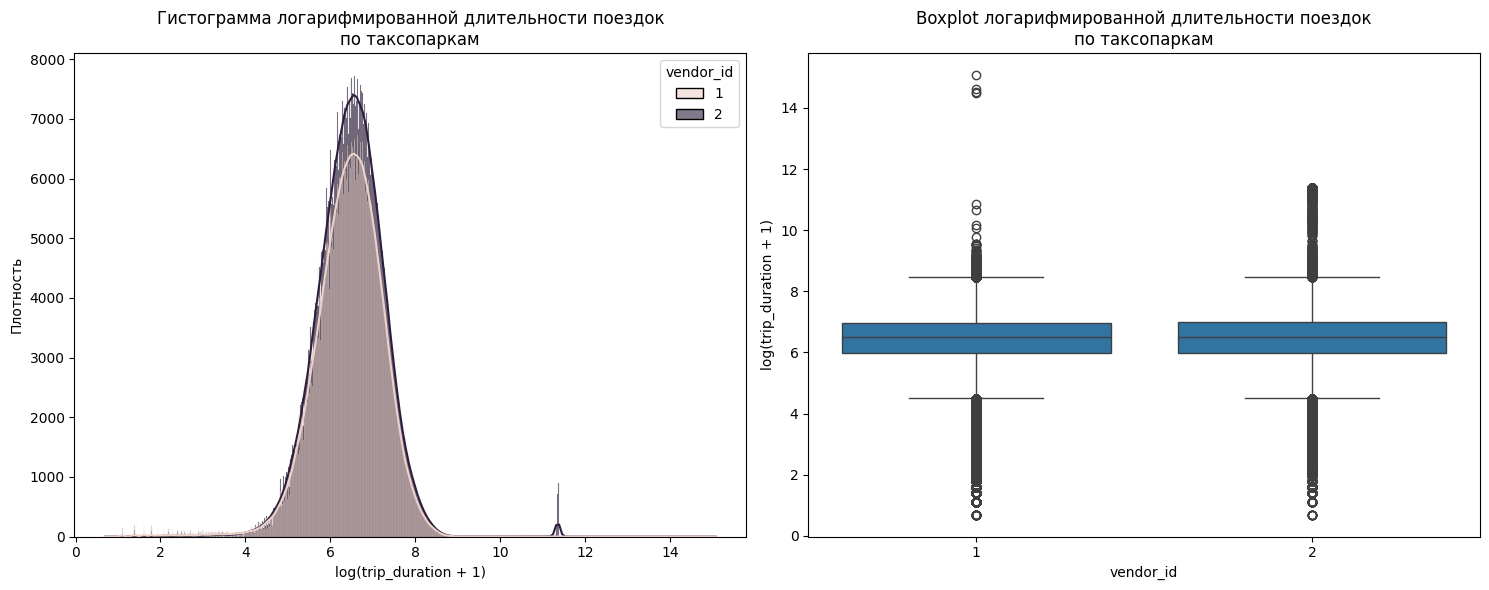

Описательная статистика по таксопаркам:
            count  mean   std   min    max  median
vendor_id                                         
1          678342  6.45  0.79  0.69  15.08    6.49
2          780302  6.48  0.80  0.69  11.37    6.50

T-тест для сравнения средних:
t-статистика: -23.851
p-value: 0.000


In [19]:
#Создаем графики для сравнения распределений по vendor_id
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
#Гистограммы с KDE для каждого vendor_id
sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', 
             kde=True, alpha=0.6, ax=axes[0])
axes[0].set_title('Гистограмма логарифмированной длительности поездок\nпо таксопаркам')
axes[0].set_xlabel('log(trip_duration + 1)')
axes[0].set_ylabel('Плотность')
#Boxplot для каждого vendor_id
sns.boxplot(data=taxi_data, x='vendor_id', y='trip_duration_log', ax=axes[1])
axes[1].set_title('Boxplot логарифмированной длительности поездок\nпо таксопаркам')
axes[1].set_xlabel('vendor_id')
axes[1].set_ylabel('log(trip_duration + 1)')
plt.tight_layout()
plt.show()
# Дополнительная статистика для сравнения
print("Описательная статистика по таксопаркам:")
vendor_stats = taxi_data.groupby('vendor_id')['trip_duration_log'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(2)
print(vendor_stats)
#Проверка статистической значимости различий
from scipy import stats
vendor_1 = taxi_data[taxi_data['vendor_id'] == 1]['trip_duration_log']
vendor_2 = taxi_data[taxi_data['vendor_id'] == 2]['trip_duration_log']
#T-тест для сравнения средних
t_stat, p_value = stats.ttest_ind(vendor_1, vendor_2, equal_var=False)
print(f"\nT-тест для сравнения средних:")
print(f"t-статистика: {t_stat:.3f}")
print(f"p-value: {p_value:.3f}")

Распределения не отличаются. Признак vendor_id не имеет значения при построении модели

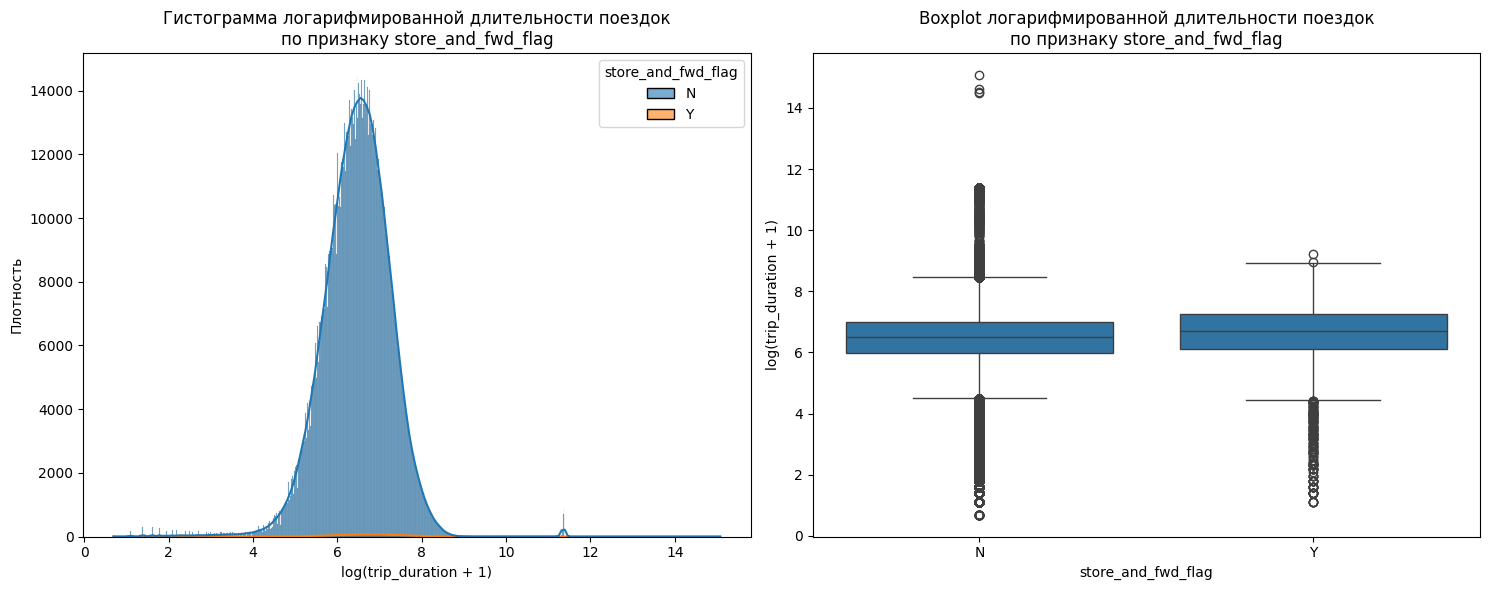

Описательная статистика по store_and_fwd_flag:
                      count  mean   std   min    max  median
store_and_fwd_flag                                          
N                   1450599  6.47  0.79  0.69  15.08     6.5
Y                      8045  6.63  0.95  1.10   9.21     6.7

T-тест для сравнения средних:
t-статистика: -15.560
p-value: 0.000


In [20]:
#Создаем графики для сравнения распределений по store_and_fwd_flag
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
#Гистограммы с KDE для каждого значения флага
sns.histplot(data=taxi_data, x='trip_duration_log', hue='store_and_fwd_flag', 
             kde=True, alpha=0.6, ax=axes[0], common_norm=False)
axes[0].set_title('Гистограмма логарифмированной длительности поездок\nпо признаку store_and_fwd_flag')
axes[0].set_xlabel('log(trip_duration + 1)')
axes[0].set_ylabel('Плотность')
#Boxplot для каждого значения флага
sns.boxplot(data=taxi_data, x='store_and_fwd_flag', y='trip_duration_log', ax=axes[1])
axes[1].set_title('Boxplot логарифмированной длительности поездок\nпо признаку store_and_fwd_flag')
axes[1].set_xlabel('store_and_fwd_flag')
axes[1].set_ylabel('log(trip_duration + 1)')
plt.tight_layout()
plt.show()
#Дополнительная статистика для сравнения
print("Описательная статистика по store_and_fwd_flag:")
flag_stats = taxi_data.groupby('store_and_fwd_flag')['trip_duration_log'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(2)
print(flag_stats)
#Проверка статистической значимости различий
flag_N = taxi_data[taxi_data['store_and_fwd_flag'] == 'N']['trip_duration_log']
flag_Y = taxi_data[taxi_data['store_and_fwd_flag'] == 'Y']['trip_duration_log']
#T-тест для сравнения средних
t_stat, p_value = stats.ttest_ind(flag_N, flag_Y, equal_var=False)
print(f"\nT-тест для сравнения средних:")
print(f"t-статистика: {t_stat:.3f}")
print(f"p-value: {p_value:.3f}")

Store_and_fwd_flag имеет значение при построении модели

### Распределение количества поездок по часам

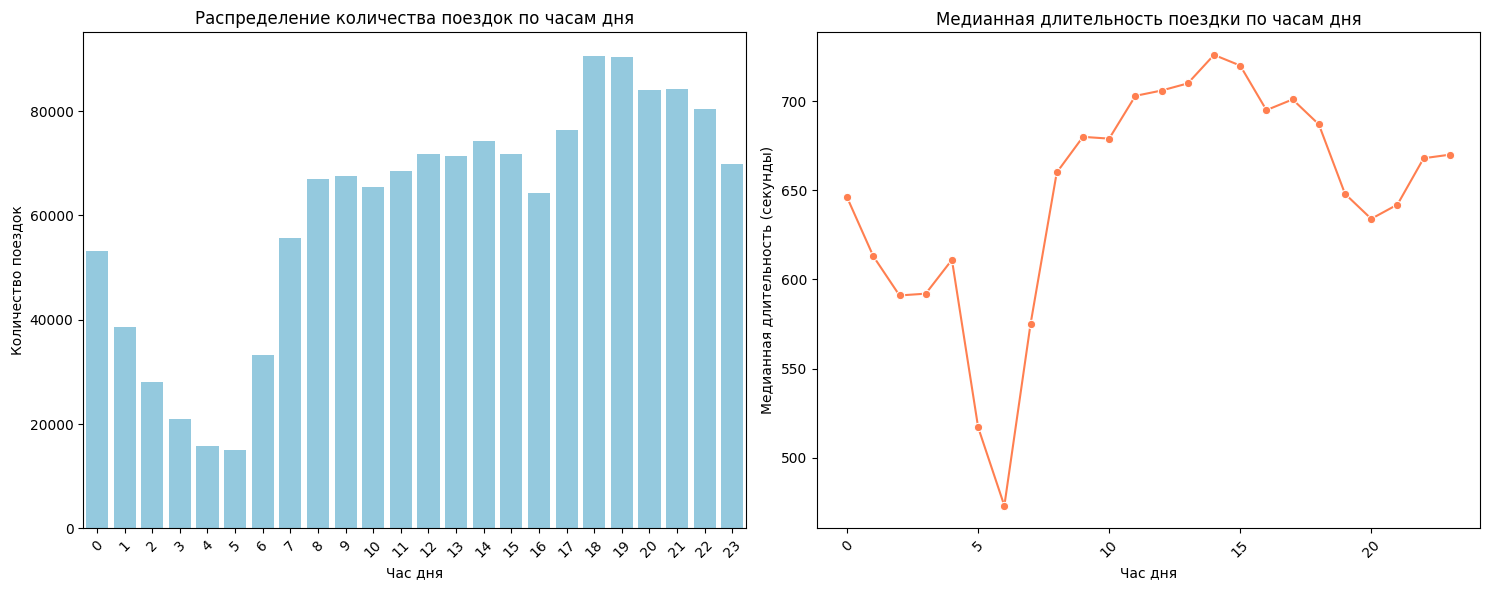

Меньше всего поездок в 5:00 часов (15002 поездок)
Пик медианной длительности поездок в 14:00 часов (726.0 секунд)
Максимальное количество поездок в 18:00 часов (90600 поездок)
Минимальная медианная длительность в 6:00 часов (473.0 секунд)


In [21]:
#Создаем столбец с часом посадки
taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour
#Создаем графики
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
#Распределение количества поездок по часам дня
hourly_counts = taxi_data['pickup_hour'].value_counts().sort_index()
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, ax=axes[0], color='skyblue')
axes[0].set_title('Распределение количества поездок по часам дня')
axes[0].set_xlabel('Час дня')
axes[0].set_ylabel('Количество поездок')
axes[0].tick_params(axis='x', rotation=45)
#Медианная длительность поездки по часам дня
hourly_median_duration = taxi_data.groupby('pickup_hour')['trip_duration'].median()
sns.lineplot(x=hourly_median_duration.index, y=hourly_median_duration.values, 
             ax=axes[1], marker='o', color='coral')
axes[1].set_title('Медианная длительность поездки по часам дня')
axes[1].set_xlabel('Час дня')
axes[1].set_ylabel('Медианная длительность (секунды)')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

min_hour_count = hourly_counts.idxmin()
min_count = hourly_counts.min()
max_median_hour = hourly_median_duration.idxmax()
max_median_duration = hourly_median_duration.max()
print(f"Меньше всего поездок в {min_hour_count}:00 часов ({min_count} поездок)")
print(f"Пик медианной длительности поездок в {max_median_hour}:00 часов ({max_median_duration:.1f} секунд)")
#Дополнительная информация
print(f"Максимальное количество поездок в {hourly_counts.idxmax()}:00 часов ({hourly_counts.max()} поездок)")
print(f"Минимальная медианная длительность в {hourly_median_duration.idxmin()}:00 часов ({hourly_median_duration.min():.1f} секунд)")

### Частота поездок в зависимости от дня недели

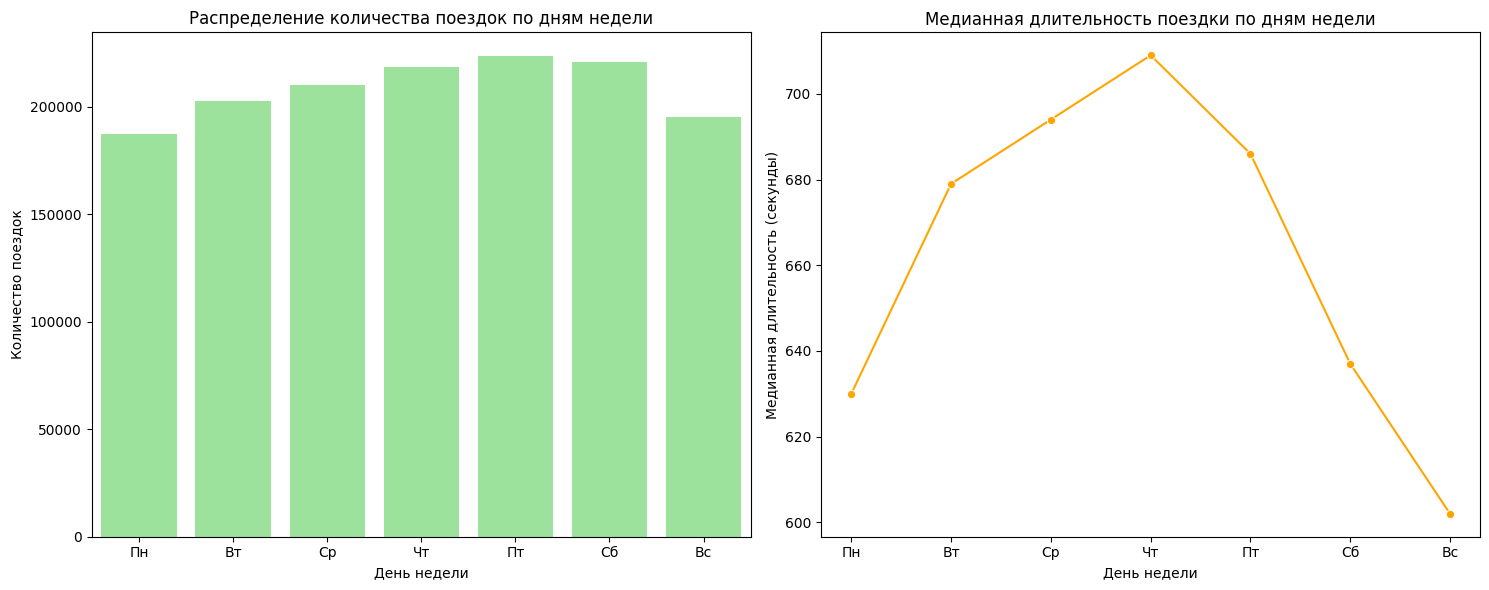

Анализ результатов:
Больше всего поездок совершается в Пт (223533 поездок)
Наименьшая медианная длительность поездок в Вс (602.0 секунд)


In [22]:
#Названия дней недели для подписей
weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
#Создаем графики
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
#Распределение количества поездок по дням недели
weekday_counts = taxi_data['pickup_day_of_week'].value_counts().sort_index()
sns.barplot(x=weekday_names, y=weekday_counts.values, ax=axes[0], color='lightgreen')
axes[0].set_title('Распределение количества поездок по дням недели')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Количество поездок')
#Медианная длительность поездки по дням недели
weekday_median_duration = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()
sns.lineplot(x=weekday_names, y=weekday_median_duration.values, 
             ax=axes[1], marker='o', color='orange')
axes[1].set_title('Медианная длительность поездки по дням недели')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Медианная длительность (секунды)')
plt.tight_layout()
plt.show()

max_weekday = weekday_counts.idxmax()
max_weekday_name = weekday_names[max_weekday]
max_count = weekday_counts.max()
min_median_weekday = weekday_median_duration.idxmin()
min_median_weekday_name = weekday_names[min_median_weekday]
min_median_duration = weekday_median_duration.min()
print("Анализ результатов:")
print(f"Больше всего поездок совершается в {max_weekday_name} ({max_count} поездок)")
print(f"Наименьшая медианная длительность поездок в {min_median_weekday_name} ({min_median_duration:.1f} секунд)")

### Теловая карта времени

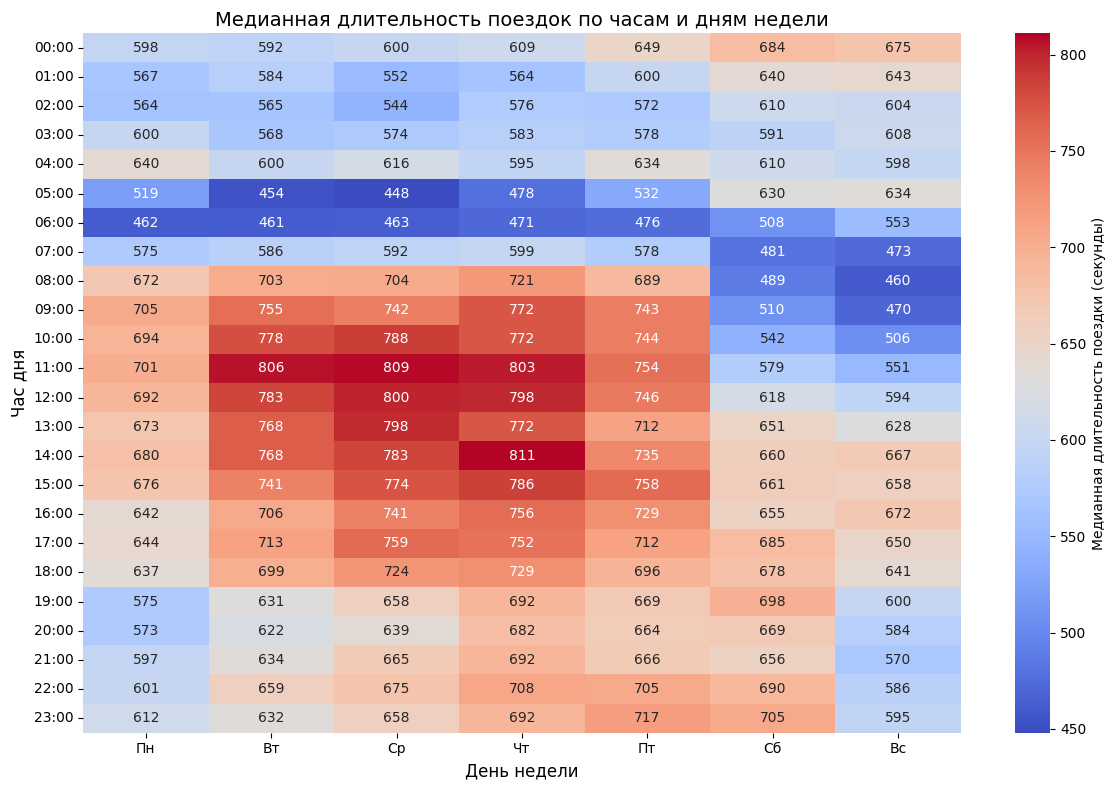

Анализ тепловой карты:
Самая высокая медианная длительность: 811 сек в 14:00 Чт
Самая низкая медианная длительность: 448 сек в 5:00 Ср


In [23]:
#Создаем сводную таблицу
pivot_table = taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median'
)
#Визуализация тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table,
    cmap='coolwarm',
    annot=True,
    fmt='.0f',
    cbar_kws={'label': 'Медианная длительность поездки (секунды)'},
    xticklabels=weekday_names,
    yticklabels=[f'{h:02d}:00' for h in range(24)]
)
plt.title('Медианная длительность поездок по часам и дням недели', fontsize=14)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Час дня', fontsize=12)
plt.tight_layout()
plt.show()
#Дополнительный анализ - находим самые загруженные временные периоды
max_duration = pivot_table.max().max()
max_coords = np.where(pivot_table == max_duration)
max_hour = pivot_table.index[max_coords[0][0]]
max_day = pivot_table.columns[max_coords[1][0]]
min_duration = pivot_table.min().min()
min_coords = np.where(pivot_table == min_duration)
min_hour = pivot_table.index[min_coords[0][0]]
min_day = pivot_table.columns[min_coords[1][0]]
print("Анализ тепловой карты:")
print(f"Самая высокая медианная длительность: {max_duration:.0f} сек в {max_hour}:00 {weekday_names[max_day]}")
print(f"Самая низкая медианная длительность: {min_duration:.0f} сек в {min_hour}:00 {weekday_names[min_day]}")

### Географическое расположение точек начала и завершения поездок

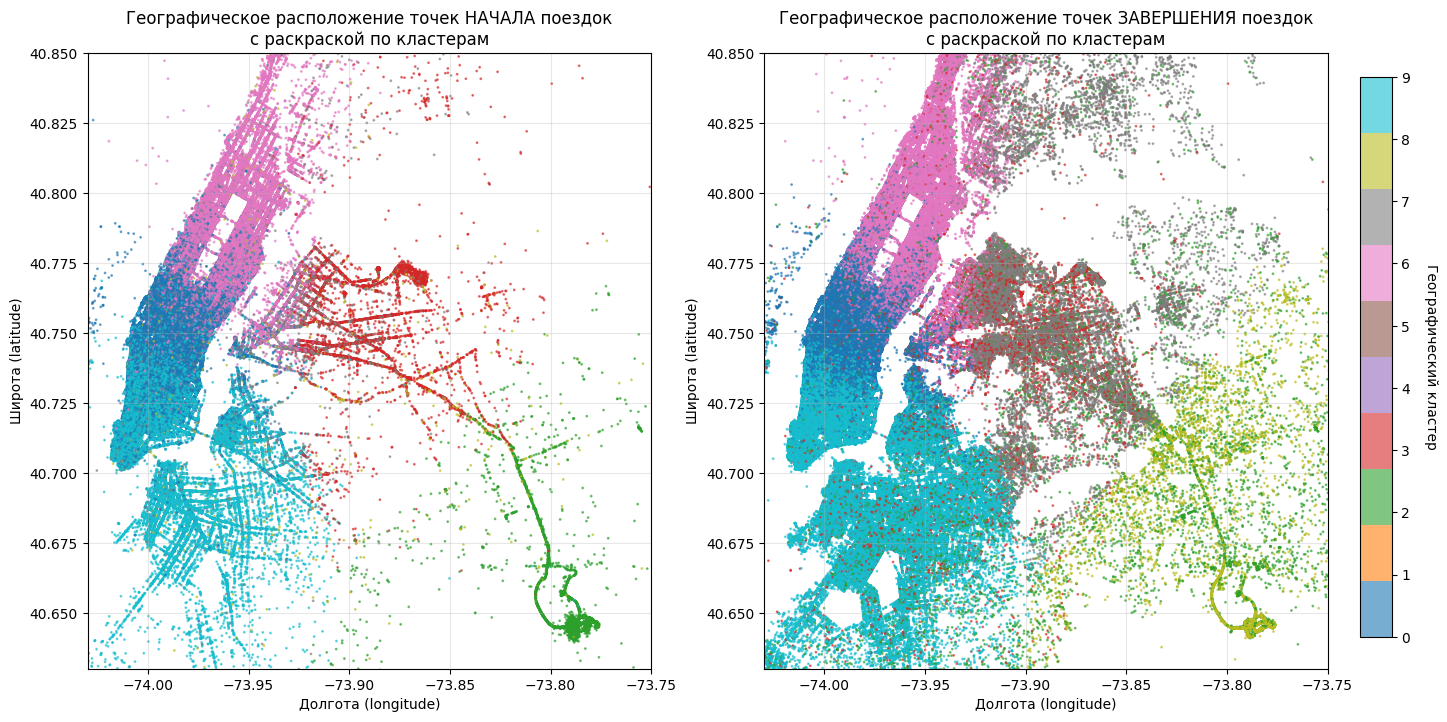

In [24]:
#Устанавливаем границы Нью-Йорка
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
#Создаем графики
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
#Диаграмма рассеяния точек начала поездок
scatter1 = axes[0].scatter(
    taxi_data['pickup_longitude'],
    taxi_data['pickup_latitude'],
    c=taxi_data['geo_cluster'],
    cmap='tab10',
    s=1,  #уменьшаем размер точек
    alpha=0.6
)
axes[0].set_xlim(city_long_border)
axes[0].set_ylim(city_lat_border)
axes[0].set_title('Географическое расположение точек НАЧАЛА поездок\nс раскраской по кластерам', fontsize=12)
axes[0].set_xlabel('Долгота (longitude)')
axes[0].set_ylabel('Широта (latitude)')
axes[0].grid(True, alpha=0.3)

#Диаграмма рассеяния точек завершения поездок
scatter2 = axes[1].scatter(
    taxi_data['dropoff_longitude'],
    taxi_data['dropoff_latitude'],
    c=taxi_data['geo_cluster'],
    cmap='tab10',
    s=1,  #уменьшаем размер точек
    alpha=0.6
)
axes[1].set_xlim(city_long_border)
axes[1].set_ylim(city_lat_border)
axes[1].set_title('Географическое расположение точек ЗАВЕРШЕНИЯ поездок\nс раскраской по кластерам', fontsize=12)
axes[1].set_xlabel('Долгота (longitude)')
axes[1].set_ylabel('Широта (latitude)')
axes[1].grid(True, alpha=0.3)
#Добавляем цветовую легенду на отдельной оси
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter1, cax=cbar_ax)
cbar.set_label('Географический кластер', rotation=270, labelpad=20)
plt.subplots_adjust(right=0.9)  #оставляем место для colorbar
plt.show()

## Отбор и преобразование признаков

In [25]:
#Содержание таблицы
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458644, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_day_of_week', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'direction', 'geo_cluster', 'temperature',
       'visibility', 'wind speed', 'precip', 'events', 'trip_duration_log',
       'pickup_hour'],
      dtype='object')


In [26]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.498521,99.970196,6,4.4,8.0,27.8,0.3,NaN,6.122493,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,NaN,6.498282,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,NaN,7.661527,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,NaN,6.063785,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,1.188588,179.473585,6,9.4,16.1,9.3,0.0,NaN,6.077642,13


### Предупреждение утечки данных

В данных присутствует уникальный id для каждой поездки - не несет информации.\
Также есть время окончания поездки. Время начала мы узнаем, как только поездка начинается, время окончания заранее знать нельзя, это предопределяло бы длительность поездки - возомжна утечка. Эти данные нужно удалить

In [27]:
#Исключаем неинформативные признаки и признаки с утечкой
columns_to_drop = ['id', 'dropoff_datetime']
train_data_cleaned = train_data.drop(columns=columns_to_drop, axis=1)
print(f"После исключения столбцов осталось: {train_data_cleaned.shape[1]} столбцов")
print(f"Удаленные столбцы: {columns_to_drop}")
print(f"Оставшиеся столбцы: {list(train_data_cleaned.columns)}")
#Проверка
print(f"Исходное количество столбцов: {train_data.shape[1]}")
print(f"После удаления 2 столбцов: {train_data_cleaned.shape[1]}")
print(f"Удаленные: ['id', 'dropoff_datetime']")

После исключения столбцов осталось: 25 столбцов
Удаленные столбцы: ['id', 'dropoff_datetime']
Оставшиеся столбцы: ['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_day_of_week', 'pickup_holiday', 'total_distance', 'total_travel_time', 'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster', 'temperature', 'visibility', 'wind speed', 'precip', 'events', 'trip_duration_log', 'pickup_hour']
Исходное количество столбцов: 27
После удаления 2 столбцов: 25
Удаленные: ['id', 'dropoff_datetime']


In [28]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458644, 25)


### Кодирование vendor_id, store_and_fwd_flag

In [29]:
#Кодирование признака vendor_id
train_data['vendor_id_encoded'] = (train_data['vendor_id'] != 1).astype(int)
#Кодирование признака store_and_fwd_flag
train_data['store_and_fwd_flag_encoded'] = (train_data['store_and_fwd_flag'] != 'N').astype(int)
#Расчет средних значений
vendor_mean = train_data['vendor_id_encoded'].mean()
store_mean = train_data['store_and_fwd_flag_encoded'].mean()
print(f"Среднее по закодированному vendor_id: {vendor_mean:.2f}")
print(f"Среднее по закодированному store_and_fwd_flag: {store_mean:.3f}")

Среднее по закодированному vendor_id: 0.53
Среднее по закодированному store_and_fwd_flag: 0.006


### Однократкное кодирование pickup_day_of_week, geo_cluster и events

In [30]:
from sklearn.preprocessing import OneHotEncoder

#Выбираем категориальные признаки для кодирования
categorical_features = ['pickup_day_of_week', 'geo_cluster', 'events']
categorical_data = train_data[categorical_features]
#Создаем и обучаем OneHotEncoder
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
data_onehot_array = one_hot_encoder.fit_transform(categorical_data)
#Получаем имена закодированных столбцов
column_names = one_hot_encoder.get_feature_names_out(categorical_features)
#Создаем DataFrame с закодированными признаками
data_onehot = pd.DataFrame(data_onehot_array, columns=column_names)
#Выводим информацию о результате
print(f"Исходное количество категориальных признаков: {len(categorical_features)}")
print(f"Количество бинарных столбцов после one-hot кодирования: {data_onehot.shape[1]}")
print(f"Размерность полученного DataFrame: {data_onehot.shape}")

Исходное количество категориальных признаков: 3
Количество бинарных столбцов после one-hot кодирования: 18
Размерность полученного DataFrame: (1458644, 18)


Добавляем полученную таблицу с закодированными признаками

In [31]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(categorical_features, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458644, 42)


### Наблюдения и целевая переменная

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log

In [32]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все модели будем обучать на логарифмированной версии y_log. Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33

In [33]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

### Отбор нужных признаков SelectKBest

In [34]:
print("\nСтолбцы с нечисловыми данными:")
non_numeric_cols = X_train.select_dtypes(include=['object', 'category']).columns
print(non_numeric_cols.tolist())


Столбцы с нечисловыми данными:
['id', 'dropoff_datetime', 'store_and_fwd_flag']


In [35]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import model_selection

X_train = X_train.drop(columns=non_numeric_cols)
X_valid = X_valid.drop(columns=non_numeric_cols)
# Удаляем строки с NaN значениями
X_train_clean = X_train.dropna()
X_valid_clean = X_valid.dropna()
y_train_clean = y_train_log.loc[X_train_clean.index]
y_valid_clean = y_valid_log.loc[X_valid_clean.index]
#Отбор 25 лучших признаков с помощью SelectKBest
selector = SelectKBest(score_func=f_regression, k=25)
selector.fit(X_train_clean, y_train_clean)
#Получаем маску отобранных признаков
selected_mask = selector.get_support()
selected_features = X_train_clean.columns[selected_mask].tolist()
#Выводим результаты
print(f"Отобрано {len(selected_features)} признаков из {X_train_clean.shape[1]}:")
print("\nОтобранные признаки:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")
#Дополнительно: оценки важности признаков
feature_scores = selector.scores_
feature_pvalues = selector.pvalues_
print(f"\nТоп-5 признаков по F-score:")

Отобрано 25 признаков из 37:

Отобранные признаки:
 1. vendor_id
 2. passenger_count
 3. pickup_longitude
 4. pickup_latitude
 5. dropoff_longitude
 6. dropoff_latitude
 7. pickup_holiday
 8. total_distance
 9. total_travel_time
10. number_of_steps
11. haversine_distance
12. temperature
13. pickup_hour
14. vendor_id_encoded
15. store_and_fwd_flag_encoded
16. pickup_day_of_week_2
17. pickup_day_of_week_3
18. pickup_day_of_week_4
19. pickup_day_of_week_5
20. pickup_day_of_week_6
21. geo_cluster_2
22. geo_cluster_3
23. geo_cluster_6
24. geo_cluster_7
25. geo_cluster_8

Топ-5 признаков по F-score:


### Нормализация предикторов

In [36]:
from sklearn.preprocessing import MinMaxScaler
#Создаем и обучаем нормализатор на обучающей выборке
scaler = MinMaxScaler()
scaler.fit(X_train_clean)  # обучение только на тренировочных данных
#Трансформируем обе выборки
X_train_scaled = scaler.transform(X_train_clean)
X_valid_scaled = scaler.transform(X_valid_clean)
#Рассчитываем среднее арифметическое для первого предиктора валидационной выборки
first_predictor_mean = X_valid_scaled[:, 0].mean()
#Округляем до сотых
result = round(first_predictor_mean, 2)
print(f"Среднее арифметическое первого предиктора валидационной выборки: {result}")

Среднее арифметическое первого предиктора валидационной выборки: 0.53


## Решение задачи регресии

Используемая метрика:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

С учетом логарифмирования призанка
$$z_i=log(y_i+1)$$

### модель Линейной регрессии

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

#Обучение модели
model = LinearRegression()
model.fit(X_train_scaled, y_train_clean)
#Предсказания в логарифмической шкале
y_train_pred_log = model.predict(X_train_scaled)
y_valid_pred_log = model.predict(X_valid_scaled)
#Расчет RMSLE (учитывая, что целевая переменная уже в логарифмической шкале)
#RMSLE = sqrt(MSLE) = sqrt(mean((log(1+y_true) - log(1+y_pred))^2))
#Расчет RMSLE
rmsle_train = np.sqrt(mean_squared_log_error(np.exp(y_train_clean), np.exp(y_train_pred_log)))
rmsle_valid = np.sqrt(mean_squared_log_error(np.exp(y_valid_clean), np.exp(y_valid_pred_log)))
#Округление
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)
print(f"RMSLE на тренировочной выборке: {rmsle_train_rounded}")
print(f"RMSLE на валидационной выборке: {rmsle_valid_rounded}")

RMSLE на тренировочной выборке: 0.53
RMSLE на валидационной выборке: 0.53


### Полиномиальные признаки

In [38]:
from sklearn.preprocessing import PolynomialFeatures

#Создание полиномиальных признаков 2-ой степени
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)
print(f"Исходное количество признаков: {X_train_scaled.shape[1]}")
print(f"Количество признаков после полиномиального преобразования: {X_train_poly.shape[1]}")
#Обучение модели полиномиальной регрессии
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_clean)
#Предсказания
y_train_pred_log = poly_model.predict(X_train_poly)
y_valid_pred_log = poly_model.predict(X_valid_poly)
#Расчет RMSLE
def calculate_rmsle(y_true_log, y_pred_log):
    #Преобразуем из логарифмической шкалы обратно
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_train = calculate_rmsle(y_train_clean, y_train_pred_log)
rmsle_valid = calculate_rmsle(y_valid_clean, y_valid_pred_log)
#Округление до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)
print(f"RMSLE на тренировочной выборке: {rmsle_train_rounded}")
print(f"RMSLE на валидационной выборке: {rmsle_valid_rounded}")
#Анализ переобучения
print(f"\nАнализ переобучения:")
print(f"Разница между валидационной и тренировочной ошибкой: {round(rmsle_valid - rmsle_train, 2)}")
if rmsle_valid > rmsle_train + 0.05:  #Порог для определения переобучения
    print("Модель показывает признаки переобучения (валидационная ошибка значительно выше тренировочной)")
elif rmsle_valid > rmsle_train:
    print("Есть небольшое переобучение")
else:
    print("Модель не показывает признаков переобучения")

Исходное количество признаков: 37
Количество признаков после полиномиального преобразования: 740


MemoryError: Unable to allocate 5.34 GiB for an array with shape (969219, 740) and data type float64

### Полиномиальные признаки 2 степени: L2-регуляризация

In [39]:
from sklearn.linear_model import Ridge

#Создание полиномиальных признаков 2-ой степени
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)
print(f"Количество полиномиальных признаков: {X_train_poly.shape[1]}")
#Обучение модели Ridge регрессии с alpha=1
ridge_model = Ridge(alpha=1.0)  #L2-регуляризация
ridge_model.fit(X_train_poly, y_train_clean)
#Предсказания
y_train_pred_log = ridge_model.predict(X_train_poly)
y_valid_pred_log = ridge_model.predict(X_valid_poly)
#Расчет RMSLE
def calculate_rmsle(y_true_log, y_pred_log):
    #Преобразуем из логарифмической шкалы обратно
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_train = calculate_rmsle(y_train_clean, y_train_pred_log)
rmsle_valid = calculate_rmsle(y_valid_clean, y_valid_pred_log)
#Округление до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)
print(f"RMSLE на тренировочной выборке: {rmsle_train_rounded}")
print(f"RMSLE на валидационной выборке: {rmsle_valid_rounded}")

MemoryError: Unable to allocate 5.34 GiB for an array with shape (969219, 740) and data type float64

### Descision Tree

In [40]:
from sklearn.tree import DecisionTreeRegressor

#Обучение модели дерева решений
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_scaled, y_train_clean)
#Предсказания
y_train_pred_log = tree_model.predict(X_train_scaled)
y_valid_pred_log = tree_model.predict(X_valid_scaled)
#Расчет RMSLE
def calculate_rmsle(y_true_log, y_pred_log):
    #Преобразуем из логарифмической шкалы обратно
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_train = calculate_rmsle(y_train_clean, y_train_pred_log)
rmsle_valid = calculate_rmsle(y_valid_clean, y_valid_pred_log)
#Округление до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)
print(f"RMSLE на тренировочной выборке: {rmsle_train_rounded}")
print(f"RMSLE на валидационной выборке: {rmsle_valid_rounded}")
#Анализ переобучения
print(f"\nАнализ переобучения:")
print(f"Разница между валидационной и тренировочной ошибкой: {round(rmsle_valid - rmsle_train, 2)}")
if rmsle_valid > rmsle_train + 0.1:  # Значительная разница указывает на переобучение
    print("Модель показывает сильные признаки переобучения")
elif rmsle_valid > rmsle_train:
    print("Модель показывает умеренные признаки переобучения")
else:
    print("Модель не показывает признаков переобучения")

RMSLE на тренировочной выборке: 0.0
RMSLE на валидационной выборке: 0.56

Анализ переобучения:
Разница между валидационной и тренировочной ошибкой: 0.56
Модель показывает сильные признаки переобучения


### Вариация параметров DescisionTree

In [41]:
from sklearn.metrics import mean_squared_error

#Диапазон глубин для перебора
max_depths = range(7, 21)
train_rmse_scores = []
valid_rmse_scores = []
train_rmsle_scores = []
valid_rmsle_scores = []
#Перебор различных глубин дерева
for depth in max_depths:
    #Создание и обучение модели
    tree_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_model.fit(X_train_scaled, y_train_clean)
    #Предсказания
    y_train_pred_log = tree_model.predict(X_train_scaled)
    y_valid_pred_log = tree_model.predict(X_valid_scaled)
    #Расчет RMSE (в логарифмической шкале)
    train_rmse = np.sqrt(mean_squared_error(y_train_clean, y_train_pred_log))
    valid_rmse = np.sqrt(mean_squared_error(y_valid_clean, y_valid_pred_log))
    #Расчет RMSLE
    def calculate_rmsle(y_true_log, y_pred_log):
        y_true = np.exp(y_true_log)
        y_pred = np.exp(y_pred_log)
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    train_rmsle = calculate_rmsle(y_train_clean, y_train_pred_log)
    valid_rmsle = calculate_rmsle(y_valid_clean, y_valid_pred_log)
    train_rmse_scores.append(train_rmse)
    valid_rmse_scores.append(valid_rmse)
    train_rmsle_scores.append(train_rmsle)
    valid_rmsle_scores.append(valid_rmsle)
    print(f"Глубина {depth}: Train RMSLE={train_rmsle:.3f}, Valid RMSLE={valid_rmsle:.3f}")
    
#Построение графиков
plt.figure(figsize=(12, 6))
#График RMSE
plt.subplot(1, 2, 1)
plt.plot(max_depths, train_rmse_scores, 'o-', label='Тренировочная RMSE')
plt.plot(max_depths, valid_rmse_scores, 'o-', label='Валидационная RMSE')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('RMSE')
plt.title('RMSE vs Глубина дерева')
plt.legend()
plt.grid(True)
#График RMSLE
plt.subplot(1, 2, 2)
plt.plot(max_depths, train_rmsle_scores, 'o-', label='Тренировочная RMSLE')
plt.plot(max_depths, valid_rmsle_scores, 'o-', label='Валидационная RMSLE')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('RMSLE')
plt.title('RMSLE vs Глубина дерева')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#Нахождение оптимальной глубины (минимум валидационной ошибки до начала переобучения)
optimal_depth_idx = np.argmin(valid_rmsle_scores)
optimal_depth = max_depths[optimal_depth_idx]
print(f"\nОптимальная глубина дерева: {optimal_depth}")
print(f"RMSLE на тренировочной выборке: {round(train_rmsle_scores[optimal_depth_idx], 2)}")
print(f"RMSLE на валидационной выборке: {round(valid_rmsle_scores[optimal_depth_idx], 2)}")
#Aнализ точки переобучения
print(f"\nАнализ кривых обучения:")
for i, depth in enumerate(max_depths):
    if i > 0 and valid_rmsle_scores[i] > valid_rmsle_scores[i-1]:
        print(f"На глубине {depth} начинается переобучение (валидационная ошибка растет)")
        break

Глубина 7: Train RMSLE=0.446, Valid RMSLE=0.448
Глубина 8: Train RMSLE=0.438, Valid RMSLE=0.441
Глубина 9: Train RMSLE=0.430, Valid RMSLE=0.435
Глубина 10: Train RMSLE=0.422, Valid RMSLE=0.431
Глубина 11: Train RMSLE=0.414, Valid RMSLE=0.430
Глубина 12: Train RMSLE=0.405, Valid RMSLE=0.430
Глубина 13: Train RMSLE=0.394, Valid RMSLE=0.434
Глубина 14: Train RMSLE=0.382, Valid RMSLE=0.438
Глубина 15: Train RMSLE=0.367, Valid RMSLE=0.446
Глубина 16: Train RMSLE=0.352, Valid RMSLE=0.454
Глубина 17: Train RMSLE=0.335, Valid RMSLE=0.464
Глубина 18: Train RMSLE=0.317, Valid RMSLE=0.474
Глубина 19: Train RMSLE=0.298, Valid RMSLE=0.484


MemoryError: could not allocate 16777216 bytes

### RandomForest

In [42]:
from sklearn.ensemble import RandomForestRegressor

#Создание и обучение модели случайного леса
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    n_jobs=-1  #для ускорения вычислений (использует все ядра процессора)
)
rf_model.fit(X_train_scaled, y_train_clean)
#Предсказания
y_train_pred_log = rf_model.predict(X_train_scaled)
y_valid_pred_log = rf_model.predict(X_valid_scaled)
#Расчет RMSLE
def calculate_rmsle(y_true_log, y_pred_log):
    #Преобразуем из логарифмической шкалы обратно
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_train = calculate_rmsle(y_train_clean, y_train_pred_log)
rmsle_valid = calculate_rmsle(y_valid_clean, y_valid_pred_log)
#Округление до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)

print(f"RMSLE на тренировочной выборке: {rmsle_train_rounded}")
print(f"RMSLE на валидационной выборке: {rmsle_valid_rounded}")

# Дополнительная информация о модели
print(f"\nИнформация о модели:")
print(f"Количество деревьев: {rf_model.n_estimators}")
print(f"Максимальная глубина: {rf_model.max_depth}")
print(f"Минимальное samples для разделения: {rf_model.min_samples_split}")
print(f"Количество признаков: {rf_model.n_features_in_}")

# Анализ переобучения
print(f"\nАнализ переобучения:")
print(f"Разница между ошибками: {round(rmsle_valid - rmsle_train, 2)}")
if rmsle_valid > rmsle_train + 0.05:
    print("Есть признаки переобучения")
else:
    print("Переобучение минимально")

MemoryError: Unable to allocate 137. MiB for an array with shape (969219, 37) and data type float32

### Gradient Boosting

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

#Создание и обучение модели градиентного бустинга
gb_model = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train_clean)
#Предсказания
y_train_pred_log = gb_model.predict(X_train_scaled)
y_valid_pred_log = gb_model.predict(X_valid_scaled)
#Расчет RMSLE
def calculate_rmsle(y_true_log, y_pred_log):
    #Преобразуем из логарифмической шкалы обратно
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_train = calculate_rmsle(y_train_clean, y_train_pred_log)
rmsle_valid = calculate_rmsle(y_valid_clean, y_valid_pred_log)
#Округление до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)
print(f"RMSLE на тренировочной выборке: {rmsle_train_rounded}")
print(f"RMSLE на валидационной выборке: {rmsle_valid_rounded}")
#Дополнительная информация о модели
print(f"\nИнформация о модели:")
print(f"Количество деревьев: {gb_model.n_estimators_}")
print(f"Скорость обучения: {gb_model.learning_rate}")
print(f"Максимальная глубина: {gb_model.max_depth}")
print(f"Минимальное samples для разделения: {gb_model.min_samples_split}")
#Анализ переобучения
print(f"\nАнализ переобучения:")
print(f"Разница между ошибками: {round(rmsle_valid - rmsle_train, 2)}")
if rmsle_valid > rmsle_train + 0.05:
    print("Есть признаки переобучения")
else:
    print("Переобучение минимально")

MemoryError: Unable to allocate 137. MiB for an array with shape (969219, 37) and data type float32